Heat load calculation (Wendelstein 7-X)
================================

This example shows how to create heat-load distribution plots for Wendelstein 7-X. First, we need to perform some setup to make sure W7-X data are available.

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration.

In [3]:
field = w7x.standard()
geometry = w7x.op21Geometry()

grid = w7x.defaultGrid()
grid.nR = 128
grid.nZ = 128
grid.nPhi = 32

In [4]:
field = field.compute(grid)
geometry = geometry.index(w7x.defaultGeometryGrid())

The tracing calculations underlying the anisotropic diffusion process are very expensive and dominate the computation time. To reduce them, we can pre-compute a global mapping of the field lines, which reduces field line tracing to a series of interpolations. Here, we use the triangular planes of W7-X, where both the plasma core and the islands have favorable aspect ratios, as our remapping planes.

In [5]:
mapping = fsc.flt.computeMapping(
    field,
    np.radians(72 * np.arange(0, 5)), # Mapping planes
    r = np.linspace(4, 7, 200), # R values for mapping grid
    z = np.linspace(-1.5, 1.5, 200), # Z values for mapping grid
    stepSize = 0.01, # Step size for tracing computation
    distanceLimit = 7 * 2 * np.pi / 8 # Distance limit for tracing computation (no field line needed to be longer than 1/10th of device)
)

From now on, we can accelerate all computations with the mapping by passing it as an additional argument.
Before we can run the calculation, we need to determine the seeding points for it. Our strategy here is to find the LCFS, then move a bit inward.

In [6]:
pInside = [5.5, 0, 0]
pOutside = [6.5, 0, 0]

lcfs = fsc.flt.findLCFS(field, geometry, pOutside, pInside, mapping = mapping)

In [7]:
pStart = lcfs + [-0.012, 0, 0]
print(lcfs, pStart)

[6.20675202 0.         0.        ] [6.19475202 0.         0.        ]


In [8]:
startPlanes = np.linspace(0 , 2 / 5 * np.pi, 100, endpoint = False)
nTurns = 220
xSurf, ySurf, zSurf, _, _ = fsc.flt.poincareInPhiPlanes(pStart, field, startPlanes, nTurns, mapping = mapping, stepSize = 1)

Let's take a look at our starting surface

(100, 220)

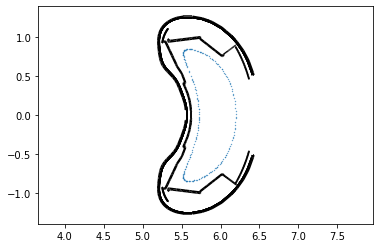

In [9]:
rSurf = np.sqrt(xSurf**2 + ySurf**2)
plt.scatter(rSurf[0], zSurf[0], s = 0.1)
geometry.plotCut(startPlanes[0], color='k')
plt.axis("equal")
xSurf.shape

Since the surface looks OK we can now start to do our tracing on the nTurns * nPlanes = 220 * 100 = 22000 points we obtained. Since we want to do diffusive tracing, we enable the parallel diffusion model. Because we use field line mapping for the parallel tracing calculation, the only limitation for our step size is how much we will tolerate the geometry intersection tests (which are based on line-casts between adjacent field line positions) to deviate from the exact field line.

In [10]:
traceResult = fsc.flt.trace(
    [xSurf, ySurf, zSurf], field, geometry,
    distanceLimit = 0, # Disable distance limit
    collisionLimit = 1, # Terminate field line on first collision
    meanFreePath = 1, meanFreePathGrowth = 0.1,
    parallelDiffusionCoefficient = 1,
    # parallelConvectionVelocity = 1,
    isotropicDiffusionCoefficient = 1e-7,
    mapping = mapping, stepSize = 0.2
)

The result of flt.trace is a superset of the Poincare and connection-length functions (in fact these functions just call trace and return part of the result). Of interest for us is the dict entry 'endPoints', which contains 4 pieces of information about the end points: Their x, y, and z coordinates as well as the length of the field line (which we don't care about here). Since we know the final distribution to be Stellarator-symmetric, we symmetrize the heat loads between our divertors to get better statistics.

In [11]:
print(traceResult.keys())
print(traceResult['endPoints'].shape)
xyz = traceResult['endPoints'][0:3]
xyz = fsc.flt.symmetrize(xyz, nSym = 5, stellaratorSymmetric = True)
print(xyz.shape, xyz[0].size)

dict_keys(['endPoints', 'poincareHits', 'stopReasons', 'fieldLines', 'fieldStrengths', 'endTags', 'responseSize'])
(4, 100, 220)
(3, 10, 100, 220) 220000


To obtain the heat loads from the point cloud, we use the 'hfcam' module. To do that, we need to follow the following steps:
- Define a projection view
- Build a camera that contains a rasterized geometry mesh and infos about the rasterization.
- Render the points into the camera image.

In [19]:
camGeo = w7x.divertor('OP21')# + w7x.baffles('OP21')
camProj = fsc.hfcam.toroidalProjection(
    w = 2500, h = 1200,
    #w = 625, h = 300,
    phi = np.radians(7), rTarget = 5.8, zTarget = -0.5,
    verticalInclination = np.radians(30), horizontalInclination = 0,
    distance = 0.5, viewportHeight = 2.5,
    fieldOfView = np.radians(0)
)
cam = fsc.hfcam.make(camProj, camGeo, depthTolerance = 0)

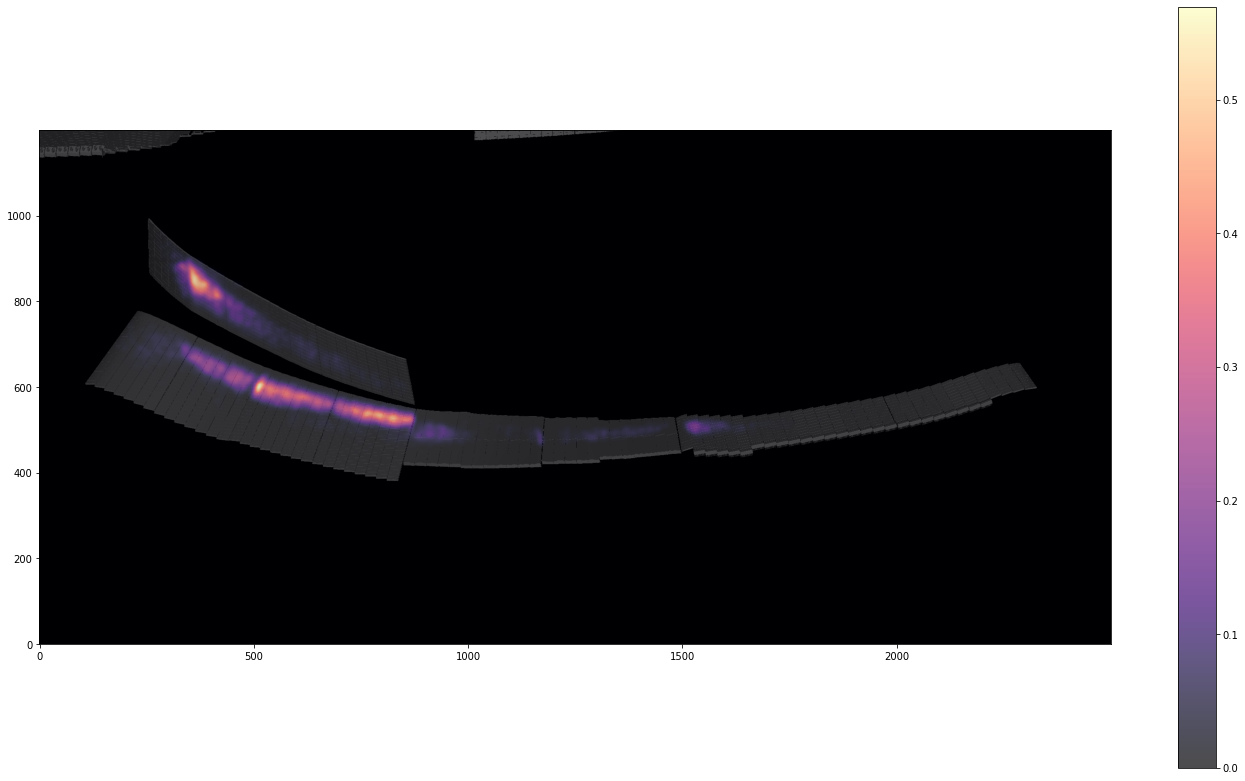

In [20]:
camData = cam.getData()
detBuf = np.asarray(camData.determinantBuffer)
cam.clear()
cam.addPoints(xyz, r = 0.015)
result = cam.get()

plt.figure(figsize = (24, 14))
plt.imshow(detBuf.T, origin ='lower', cmap = 'gray')
plt.imshow(np.asarray(result.image).T / xyz.size * 3, origin = 'lower', cmap = 'magma', alpha=0.7)
plt.colorbar()